<a href="https://colab.research.google.com/github/vassilybar/cs231n_assignments_colab/blob/master/assignment_1/features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [17]:
!rm -rf * && \
 wget 'http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip' && \
 unzip 'spring1718_assignment1.zip' && \
 mv assignment1/cs231n . && \
 pushd cs231n/datasets && \
 ./get_datasets.sh && \
 popd && \
 rm -rf assignment1 && \
 rm -rf cs231n/__pycache__

--2019-01-18 11:50:22--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.03s   

2019-01-18 11:50:22 (2.48 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]

Archive:  spring1718_assignment1.zip
   creating: assignment1/
 extracting: assignment1/.gitignore  
   creating: assignment1/.ipynb_checkpoints/
  inflating: assignment1/.ipynb_checkpoints/features-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/knn-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/softmax-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/svm-checkpoint.ipynb  
  inf

In [18]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [33]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [34]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
def svm_loss_vectorized(W, X, y, reg):
  
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  num_train = X.shape[0]
  scores = X.dot(W)
  margin = np.maximum(0, scores - scores[range(num_train), y].reshape(-1,1) + 1)
  margin[range(num_train), y] = 0
  loss = margin.sum() / num_train + reg * np.sum(W * W)
  
  indicator_matrix = np.zeros(margin.shape)
  indicator_matrix[margin > 0] = 1
  indicator_matrix[range(num_train), y] = -1 * np.sum(indicator_matrix, axis=1)
  
  dW = X.T.dot(indicator_matrix)
  dW /= num_train
  dW += 2 * reg * W
  
  return loss, dW

In [0]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      idxs = np.random.choice(num_train, batch_size)
      X_batch = X[idxs]
      y_batch = y[idxs]
      
      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
     
      self.W += - learning_rate * grad
      
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(X.dot(self.W), axis=1)
    
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [37]:
# Use the validation set to tune the learning rate and regularization strength

# from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, reg)] = (train_accuracy, val_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.073061 val accuracy: 0.053000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.092633 val accuracy: 0.093000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.308388 val accuracy: 0.312000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.087694 val accuracy: 0.080000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.414163 val accuracy: 0.423000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.399184 val accuracy: 0.395000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415755 val accuracy: 0.427000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.413551 val accuracy: 0.397000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.317041 val accuracy: 0.300000
best validation accuracy achieved during cross-validation: 0.427000


In [38]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


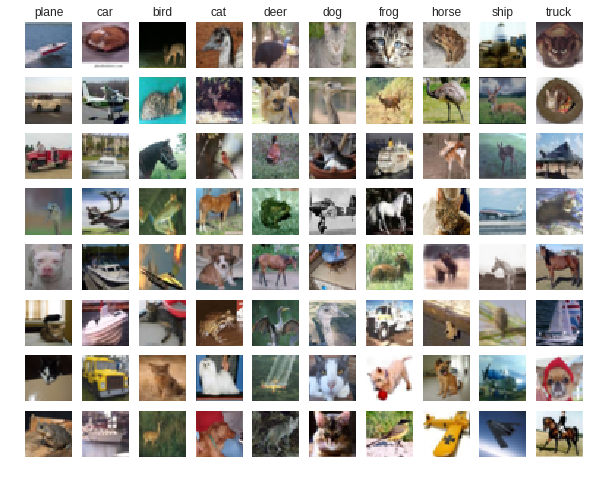

In [39]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [0]:
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  
  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    relu = lambda x: np.maximum(0, x)
    y1 = X.dot(W1) + b1.T
    h1 = relu(y1)
    scores = h1.dot(W2) + b2.T
            
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    scores -= np.max(scores, axis=1).reshape(-1,1)
    scores = np.exp(scores)
    scores = scores / np.sum(scores, axis=1).reshape(-1,1)
    loss = - np.sum(np.log(scores[range(N), y])) / N
    loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
   
    # Backward pass: compute gradients
    grads = {}
    
    scores[range(N), y] -= 1
    scores /= N
    
    dW2 = h1.T.dot(scores) + 2 * reg * W2
    db2 = np.sum(scores, axis=0)
    dh1 = scores.dot(W2.T)
    dy1 = dh1 * (y1 > 0)
    dW1 = X.T.dot(dy1) + 2 * reg * W1
    db1 = np.sum(dy1, axis=0)
    
    grads['W2'] = dW2
    grads['b2'] = db2
    grads['W1'] = dW1
    grads['b1'] = db1
    
    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
       
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      idxs = np.random.choice(num_train, batch_size)
      X_batch = X[idxs]
      y_batch = y[idxs]
      
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      self.params['W1'] -= learning_rate * grads['W1']
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b1'] -= learning_rate * grads['b1']
      self.params['b2'] -= learning_rate * grads['b2']
      
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    
    y_pred = None

    y1 = X.dot(self.params['W1']) + self.params['b1']
    h1 = np.maximum(0, y1)
    y2 = h1.dot(self.params['W2']) + self.params['b2']
    y_pred = np.argmax(y2, axis=1)
    
    return y_pred

In [41]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [48]:
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_val = -1
learning_rates = [1e-3, 1]
regs = [0, 1e-2, 1e-4]

for lr in learning_rates:
  for reg in regs:  
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1500, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg=reg)
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
              lr, reg, train_accuracy, val_accuracy))
          
print('best validation accuracy achieved during cross-validation: %f' % best_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-03 reg 0.000000e+00 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.100041 val accuracy: 0.098000
lr 1.000000e-03 reg 1.000000e-04 train accuracy: 0.099857 val accuracy: 0.107000
lr 1.000000e+00 reg 0.000000e+00 train accuracy: 0.729041 val accuracy: 0.570000
lr 1.000000e+00 reg 1.000000e-02 train accuracy: 0.513816 val accuracy: 0.494000
lr 1.000000e+00 reg 1.000000e-04 train accuracy: 0.717612 val accuracy: 0.583000
best validation accuracy achieved during cross-validation: 0.583000


In [49]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.555
